В нашей игре проводился А/В тест. Каждый игрок был распределен в одну из групп (контрольная или тестовая) и получил идентификатор 0 или 1 соответственно. В тесте мы хотели проверить гипотезу о том, что изменения в тестовой группе положительно повлияют на денежные показатели: ARPU, ARPPU и конверсию. Проведите анализ А/В теста.

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
df= pd.read_csv('data.csv')
df.head()

,geo_country,test_timestamp,user_revenue,user_payments,user_id,test_group
0,Russia,2021-05-03 19:06:06.325,NaN,0,6d696b2e-f236-45b1-b770-5530b2a3b3cf,0
1,India,2021-05-04 17:13:35.877,NaN,0,3ae8cd76-14ef-4e47-99c9-637e9260205e,0
2,Russia,2021-05-01 01:56:49.796,1.223728,1,0bf7d591-a052-44a2-97a5-161791fb440d,0
3,Kazakhstan,2021-05-03 04:17:25.337,NaN,0,5f8a3459-e85d-451e-8f93-0c17664c70da,0
4,Switzerland,2021-05-20 10:49:18.064,NaN,0,f2ea93ed-b9c6-4d8b-88d0-7717f8931988,0


##### Посмотрим на наши данные с группировкой по тестам. Узнаем Сколько всего было участников, сколько платящих, сумму, количество транзакций 

In [3]:
metrics = df.groupby('test_group', as_index=False).agg({'user_id' :'count',
                                             'user_payments' :'sum',
                                              'user_revenue' : ['sum','count']
                                             })
metrics

test_group user_id user_payments  user_revenue      
               count           sum           sum count
0          0   45400         12235  17001.593107  3489
1          1   45600         11098  16090.426997  3243

##### Видно, что количество участников в обеих группах почти одинаковое, а другие характериситики отличаются примерно на 4-7% в большую сторону для контрольной группы

##### Посмотрим как распределены странны между собой . Уберем страны, где количество платяжей было меньше 300

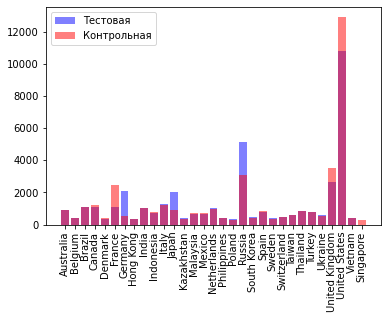

In [4]:
metric_county = df.groupby('geo_country', as_index=False).agg({'user_id' :'count','user_payments' :'sum','user_revenue' : ['sum','count']})
                                                               
metric_county[metric_county['user_id']['count']>1000]

main_county = df[df['test_group'] == 0].groupby('geo_country', as_index=False).agg({'user_id' :'count'})
main_county = main_county[main_county['user_id'] >300]

test_county = df[df['test_group'] == 1].groupby('geo_country', as_index=False).agg({'user_id' :'count'})
test_county = test_county[test_county['user_id'] >300]

plt.bar(test_county['geo_country'],test_county['user_id'], color='b',alpha=0.5,label='Тестовая' )
plt.bar(main_county['geo_country'],main_county['user_id'], color='r',alpha=0.5,label='Контрольная')
plt.xticks(rotation=90)
plt.legend()
plt.show()

##### Как видно в контрольную группу попало больше US, а в Тестовую больше RUS. Возможно поэтому есть небольшое премущество в цифрах в контрольной группе

##### Теперь посмотрим на выборсы по платежам, если они есть избавимся от 0,05% самых высоких значений. 
##### Можно просто выкинуть значения больше 99.5 процентиля или можно заменить их максимальное число на границе 99.5 процентиля

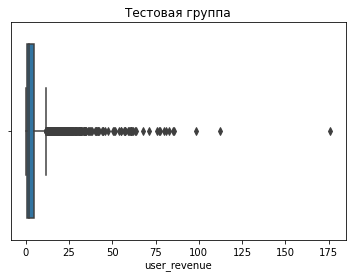

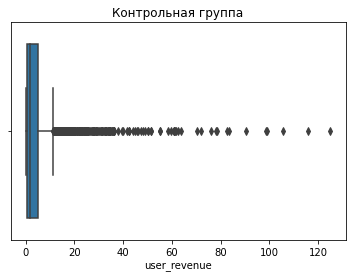

In [5]:
test_df_vibros = df[df['test_group'] == 1]
control_df_vibros = df[df['test_group'] == 0]

test_df = test_df_vibros.copy()
control_df = control_df_vibros.copy()

test_quan = np.nanquantile(test_df_vibros['user_revenue'], 0.995,axis=0)
control_quan = np.nanquantile(control_df_vibros['user_revenue'], 0.995,axis=0)


test_df['user_revenue'] = test_df_vibros['user_revenue'].apply(lambda x: test_quan if x>test_quan else x)
control_df['user_revenue'] = control_df_vibros['user_revenue'].apply(lambda x: control_quan if x>control_quan else x)

sns.boxplot(x=test_df_vibros['user_revenue'])
plt.title('Тестовая группа')
plt.show()
sns.boxplot(x=control_df_vibros['user_revenue'])
plt.title('Контрольная группа')
plt.show()



#### Переведем числа из таблицы в самом начале на bar plot

Text(0.5, 1.0, 'Платящие люди')

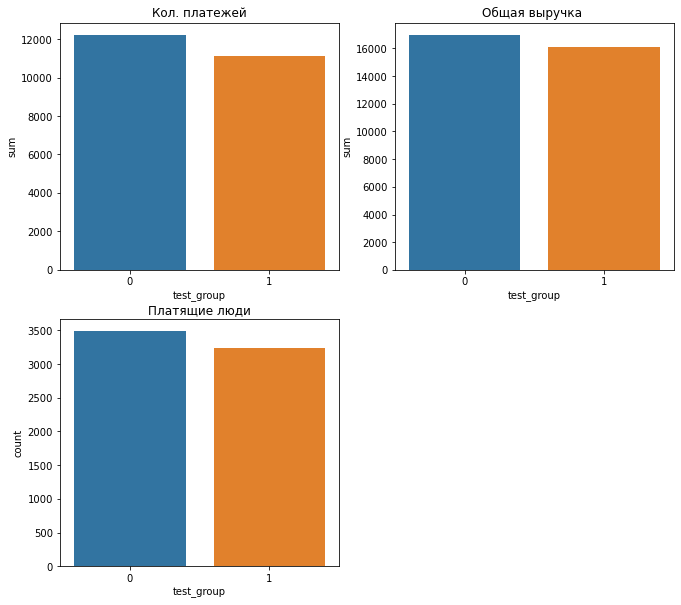

In [6]:

f = plt.figure(figsize=(11,10))
ax = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
sns.barplot(x ='test_group'  ,y=metrics['user_payments']['sum'] , data = metrics,ax=ax ).set_title('Кол. платежей')
sns.barplot(x ='test_group'  ,y=metrics['user_revenue']['sum'] , data = metrics,ax=ax2).set_title('Общая выручка ')
sns.barplot(x ='test_group'  ,y=metrics['user_revenue']['count'] , data = metrics,ax=ax3).set_title('Платящие люди')

##### Создадим два датафрейма с тестовой и контрольной группой. Рассчитаем метрики

In [7]:
test_df = df[df['test_group'] == 1]
control_df = df[df['test_group'] == 0]

#Выручка
test_revenue = test_df['user_revenue'].sum()
control_revenue = control_df['user_revenue'].sum()

#Общее количество пользователей
test_users = test_df['user_id'].count()
control_users = control_df['user_id'].count()

#Количество платящих пользователей
test_pay_users = test_df['user_revenue'].count()
control_pay_users = control_df['user_revenue'].count()

#ARPU= Revenue / Active users
test_ARPU = test_revenue/test_users
control_ARPU = control_revenue/test_users

#ARPPU = Revenue/ paying users
test_ARPPU = test_revenue/test_pay_users
control_ARPPU = control_revenue/control_pay_users

#Коневерсия = платащие пользователя / все пользователи
test_conv = test_pay_users/test_users *100
control_conv = control_pay_users/control_users *100


metrics_calc = pd.DataFrame({'Метрика': ['ARPU', 'ARPPU', 'Конверсия', ], 
                             'Тестовая группа': [test_ARPU, test_ARPPU,test_conv],
                             'Контрольная группа': [control_ARPU, control_ARPPU,control_conv]}).set_index('Метрика')
metrics_calc

,Тестовая группа,Контрольная группа
Метрика,,
ARPU,0.352860,0.372842
ARPPU,4.961587,4.872913
Конверсия,7.111842,7.685022


<AxesSubplot:xlabel='user_revenue', ylabel='Density'>

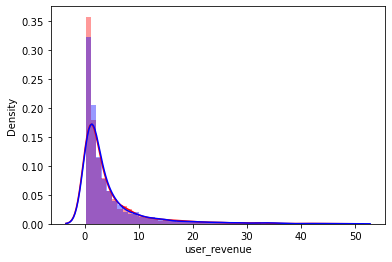

In [8]:
sns.distplot(test_df[test_df['user_revenue']<50]['user_revenue'], color='r')
sns.distplot(control_df[control_df['user_revenue'] <50]['user_revenue'], color='b')

##### Ожидаемо наше распределение имеет наибольший объем в среднем чеке 0-5$ 

##### Проверим, есть ли различия между этими метриками. 
##### Возьмем уровень значимости равный 5% (alpha)
##### Для конверсии выдвеним гипотезу H0, что конверсия тестовой группы = конверсии контрольной группы ( Cmain = Ctest), те H1 будет Cmain < Ctest
###### Найдем p value с помощью proportions_ztes, то есть теста Фишера,


In [9]:
from statsmodels.stats.proportion import proportions_ztest
alpha = 0.05
stat, pvalue = proportions_ztest([control_conv,test_conv], [control_users,test_users])
print(pvalue, pvalue<alpha)

0.8748711281315769 False


##### Для конверсии мы получили pvalue =0.87 и поэтому у нас нет оснований отвергнуть нулевую гипотезу 

##### Нулевая гипотеза ARPUtest = ARPUcontrol
##### H1 ARPUtest > ARPUcontrol
##### Будем использвать бутстрэп для проверки нулевой гипотезы, возьмем 1000 выборок размером 45000. 

In [10]:

import random

def func_ARPU(s1):
    return np.sum(s1)/len(s1)

def func_ARPPU(s1):
    return np.sum(s1)/np.count_nonzero(s1)

#ARPU
def bootstrap(test_df,control_df,func,N,column):
    diff = np.zeros((N))
    p1_arr =  np.zeros((N))
    p2_arr =  np.zeros((N))
    zz = test_df.fillna(0)
    ss = control_df.fillna(0)
    for i in range(0,N):
        s1 = random.choices(zz[column].values, k= 45000)
        s2 = random.choices(ss[column].values, k= 45000)
        p1 = func(s1)
        p2 = func(s2)
        p1_arr[i] = np.mean(p1)
        p2_arr[i] = np.mean(p2)
        diff[i] = p1 - p2
    return diff,p1_arr,p2_arr



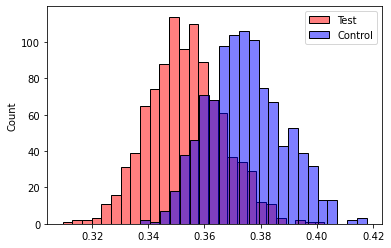

In [11]:
diff_arpu,p1_arr_arpu,p2_arr_arpu =  bootstrap(test_df,control_df,func_ARPU,1000,'user_revenue')

diff_arpu_original = test_ARPU - control_ARPU

sns.histplot(p1_arr_arpu, color='r',alpha=0.5,label ='Test')
sns.histplot(p2_arr_arpu, color='b',alpha=0.5,label ='Control')
plt.legend()
#p = np.sum(bs_rep>= mean_diff) / len(bs_rep)

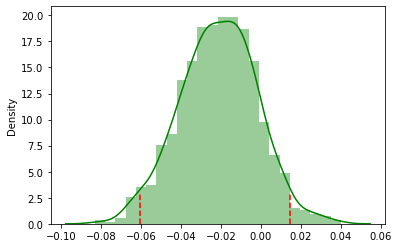

In [13]:
borders_arpu = np.percentile(diff_arpu,[2.5,97.5])
borders_arpu
sns.distplot((p1_arr_arpu-p2_arr_arpu), color='g')
plt.vlines(borders_arpu,ymin=0, ymax=3, color='r', linestyles='--')


#### Ноль вошел в наш доверительный интервал, а значит мы не отвергаем H0

##### Теперь проделаем тоже самое и для ARPPU


In [14]:
#ARPU
diff_arppu,p1_arr_arppu,p2_arr_arppu =  bootstrap(test_df,control_df,func_ARPPU,1500,'user_revenue')

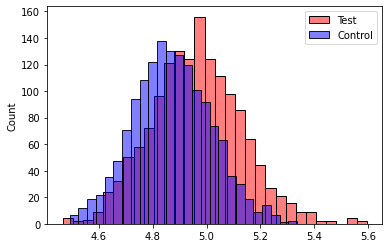

In [15]:
sns.histplot(p1_arr_arppu, color='r',alpha=0.5,label ='Test')
sns.histplot(p2_arr_arppu, color='b',alpha=0.5,label ='Control')
plt.legend()

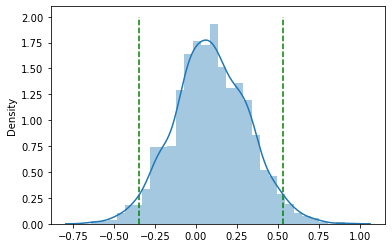

In [16]:
borders_arppu = np.percentile(diff_arppu,[2.5,97.5])
borders_arppu
sns.distplot(diff_arppu)
plt.vlines(borders_arppu,ymin=0, ymax=2, color='g', linestyles='--')

#### У ARPPU 0 тоже вошел в наш доверительный интервал, значит H0 не отвергаем 

# Итог

### Конверсия
#### Опровергнуть нулевую гипотезу нельзя, ибо p value > выбранной ошибки 

### ARPU
#### Опровергнуть нулевую гипотезу нельзя, так как 0 входит в интервал разницы групп

### ARPPU
#### Опровергнуть нулевую гипотезу нельзя, так как 0 входит в интервал разницы групп

#### Подводя итоги можно сказать, что тестовая группа не дала значительных статистических результатов в сравнение с контрольной.